<a href="https://colab.research.google.com/github/isaacfinberg/Novozymes-Enzyme-Stability-Prediction/blob/develop/BERTModel_10_23_Louis.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [2]:
!pip -q install --upgrade --force-reinstall --no-deps kaggle > log  
!mkdir -p ~/.kaggle                                          
!cp /content/gdrive/MyDrive/kaggle.json ~/.kaggle/kaggle.json >log 
!cp kaggle.json ~/.kaggle/kaggle.json > log              
!chmod 600 ~/.kaggle/kaggle.json                            
!kaggle config set -n competition -v novozymes-enzyme-stability-prediction   
!kaggle competitions download -c novozymes-enzyme-stability-prediction         
!unzip -o *.zip >> log                           
!kaggle competitions leaderboard --show                

cp: cannot stat 'kaggle.json': No such file or directory
- competition is now set to: novozymes-enzyme-stability-prediction
novozymes-enzyme-stability-prediction.zip: Skipping, found more recently modified local copy (use --force to force download)
Using competition: novozymes-enzyme-stability-prediction
 teamId  teamName                                        submissionDate       score   
-------  ----------------------------------------------  -------------------  ------  
9186580  Chris Deotte                                    2022-10-24 01:16:37  0.648   
9200132  enzymedesign                                    2022-10-22 04:53:35  0.566   
9184261  Muhammad Ahmed                                  2022-10-23 17:28:37  0.561   
9191440  Tilii                                           2022-10-23 04:29:17  0.551   
9223695  The R&D Team                                    2022-10-23 04:40:09  0.551   
9234521  Proletheus                                      2022-10-12 14:17:37  0.551  

In [3]:
import pandas as pd
import numpy as np

df = pd.read_csv('train.csv', low_memory=False); df

df.insert(0,'sequence_length',df.protein_sequence.apply(lambda x: len(x)))
df

,sequence_length,seq_id,protein_sequence,pH,data_source,tm
0,341,0,AAAAKAAALALLGEAPEVVDIWLPAGWRQPFRVFRLERKGDGVLVG...,7.0,doi.org/10.1038/s41592-020-0801-4,75.7
1,286,1,AAADGEPLHNEEERAGAGQVGRSLPQESEEQRTGSRPRRRRDLGSR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.5
2,497,2,AAAFSTPRATSYRILSSAGSGSTRADAPQVRRLHTTRDLLAKDYYA...,7.0,doi.org/10.1038/s41592-020-0801-4,40.5
3,265,3,AAASGLRTAIPAQPLRHLLQPAPRPCLRPFGLLSVRAGSARRSGLL...,7.0,doi.org/10.1038/s41592-020-0801-4,47.2
4,1451,4,AAATKSGPRRQSQGASVRTFTPFYFLVEPVDTLSVRGSSVILNCSA...,7.0,doi.org/10.1038/s41592-020-0801-4,49.5
...,...,...,...,...,...,...
31385,549,31385,YYMYSGGGSALAAGGGGAGRKGDWNDIDSIKKKDLHHSRGDEKAQG...,7.0,doi.org/10.1038/s41592-020-0801-4,51.8
31386,469,31386,YYNDQHRLSSYSVETAMFLSWERAIVKPGAMFKKAVIGFNCNVDLI...,7.0,doi.org/10.1038/s41592-020-0801-4,37.2
31387,128,31387,YYQRTLGAELLYKISFGEMPKSAQDSAENCPSGMQFPDTAIAHANV...,7.0,doi.org/10.1038/s41592-020-0801-4,64.6
31388,593,31388,YYSFSDNITTVFLSRQAIDDDHSLSLGTISDVVESENGVVAADDAR...,7.0,doi.org/10.1038/s41592-020-0801-4,50.7


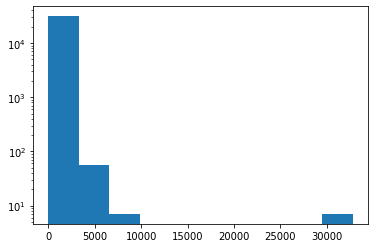

447.66951258362536 640.7187286049968


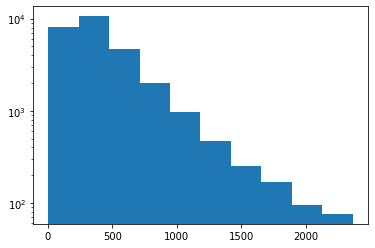

438.9336477417014 327.1179936035686


In [4]:
import matplotlib.pyplot as plt
from scipy import stats

def handle_outliers(frame, z_limit, NumFeatures):
    frame.loc[:, NumFeatures] = remove_col_outliers(frame, NumFeatures, z_limit)
    return frame.dropna()
    
def remove_col_outliers(frame, col, z_limit):
    return frame[(np.abs(stats.zscore(frame[col])) < z_limit).all(axis=1)]

sequence_lengths = df.sequence_length.values

plt.hist(sequence_lengths,log=True)
plt.show()

print(np.mean(sequence_lengths), np.std(sequence_lengths))

df_outliers_removed = handle_outliers(df, 3, ['sequence_length'])

sequence_lengths = df_outliers_removed.sequence_length.values

plt.hist(sequence_lengths,log=True)
plt.show()

print(np.mean(sequence_lengths), np.std(sequence_lengths))

In [5]:
df = df_outliers_removed

In [6]:
# https://github.com/mani-aiml/amazon-sagemaker-protein-classification/blob/main/sm-protein-classification.ipynb

!pip install transformers
!pip install Bio -q
!pip install sentencepiece
!pip install torch==1.9.0+cu111 torchvision==0.10.0+cu111 torchaudio==0.9.0 -f https://download.pytorch.org/whl/torch_stable.html
#For TPU, use: !pip install cloud-tpu-client==0.10 torch==1.12.0 https://storage.googleapis.com/tpu-pytorch/wheels/colab/torch_xla-1.12-cp37-cp37m-linux_x86_64.whl
!pip install skorch

import pandas as pd
import numpy as np
import torch
import Bio

RANDOM_SEED = 43
np.random.seed(RANDOM_SEED)
torch.manual_seed(RANDOM_SEED)


Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in links: https://download.pytorch.org/whl/torch_stable.html
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [7]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

#scaler = MinMaxScaler()
df_subset = df #.iloc[0:1000]

X = np.stack(df_subset.protein_sequence.values, axis=0)
y = np.asarray(df_subset.tm.values)
#y = scaler.fit_transform(y.reshape((-1,1)))
y = y.astype(np.float32)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.15, random_state=0)

print(X_train.shape)
print(y_train.shape)

(23430,)
(23430,)


In [10]:
import tensorflow as tf
from transformers import T5Tokenizer, T5EncoderModel
import re
import torch
#import torch_xla
#import torch_xla.core.xla_model as xm

def get_embeddings(X, device_type='gpu', batch_size=4):

  num_sequences = len(X)
  
  if device_type == 'gpu':
    dev = 'cuda'
  elif device_type == 'tpu':
    dev = xm.xla_device()
  
  df_split = pd.DataFrame(X, columns=['protein_sequence'])
  df_split.protein_sequence = df_split.protein_sequence.apply(lambda x: ' '.join([y for y in x]))

  tokenizer = T5Tokenizer.from_pretrained('Rostlab/prot_t5_xl_half_uniref50-enc', do_lower_case=False)

  model = T5EncoderModel.from_pretrained("Rostlab/prot_t5_xl_half_uniref50-enc", torch_dtype=torch.float16)
  model = model.to(dev)

  sequences = df_split.protein_sequence.values
  sequences = [re.sub(r"[UZOB]", "X", sequence) for sequence in sequences]

  dataloader = torch.utils.data.DataLoader(sequences, batch_size=batch_size)

  encoded_values = np.empty(shape=[0,1024])

  with torch.no_grad():
    i = 0
    j = 0
    for batch in dataloader:

      if i % 10 == 0:
        print('Batch %i' % i)
      
      tokenized = tokenizer.batch_encode_plus(
        batch, 
        add_special_tokens=True, 
        padding="longest"
      )

      outputs = model(
        input_ids = torch.tensor(tokenized['input_ids']).to(dev),
        attention_mask = torch.tensor(tokenized['attention_mask']).to(dev)
      )

      encoded = tf.reduce_mean(outputs.last_hidden_state.detach().cpu().numpy(),axis=1)
      
      curr_batch_size = encoded.shape[0]
      curr_seq_length = encoded.shape[1]

      encoded_padded = np.zeros((curr_batch_size,1024))
      encoded = encoded[:,0:np.min([curr_seq_length, 1024])]
      encoded_padded[:,0:curr_seq_length] = encoded

      encoded_values = np.concatenate([encoded_values, encoded_padded])

      i += 1
      j += curr_batch_size

  df_embedded = pd.DataFrame(
    encoded_values.reshape((j,1024*1)),
    columns=[k for k in range(0,1024*1)]
  )

  return df_embedded

In [11]:
train_embeddings = get_embeddings(X_train)
test_embeddings = get_embeddings(X_test)

Streaming output truncated to the last 5000 lines.
(4, 1024)
Batch 2350
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2360
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2370
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2380
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2390
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2400
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2410
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2420
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 2430
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)


Model: "sequential_3"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten_3 (Flatten)         (None, 1024)              0         
                                                                 
 dense_10 (Dense)            (None, 32)                32800     
                                                                 
 dense_11 (Dense)            (None, 1)                 33        
                                                                 
Total params: 32,833
Trainable params: 32,833
Non-trainable params: 0
_________________________________________________________________
Epoch 1/1000
129/129 [==============================] - 1s 5ms/step - loss: 465.1564 - mse: 465.1564 - val_loss: 243.2221 - val_mse: 243.2221
Epoch 2/1000
129/129 [==============================] - 0s 4ms/step - loss: 176.1526 - mse: 176.1526 - val_loss: 229.4906 - val_mse: 229.4906
Epoch 3/1000
129/129 [========

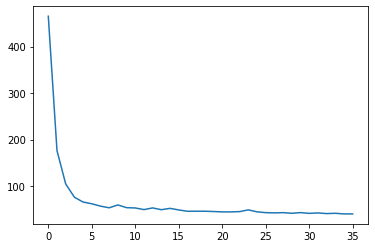

130/130 [==============================] - 0s 1ms/step


In [15]:
import tensorflow as tf
import keras

from sklearn.metrics import accuracy_score
from keras.layers import Flatten, Dense, BatchNormalization, Dropout

tf.random.set_seed(0)
GlorotInit = keras.initializers.GlorotNormal(seed=0)
LecunInit = keras.initializers.LecunNormal(seed=0)

m = keras.models.Sequential([
    Flatten(input_shape=[train_embeddings.shape[1]]),
    Dense(32, activation="relu", kernel_initializer=LecunInit),
    Dense(1)
])

m.summary()

m.compile(loss="mse", optimizer="sgd", metrics=['mse'])

callback = tf.keras.callbacks.EarlyStopping(
    monitor='val_loss',
    patience=10,
    min_delta=1,
    restore_best_weights=True,
)

hist = m.fit(train_embeddings, 
             y_train, 
             batch_size=128, 
             epochs=1000, 
             validation_split=0.3, 
             callbacks=[callback], 
             #verbose=False
)

plt.plot(hist.history['mse'])
plt.show()

y_pred = m.predict(test_embeddings)

In [16]:
from scipy.stats import spearmanr

correlation = spearmanr(y_test,y_pred)[0]
print('Spearman R on test set: %f' % correlation)

Spearman R on test set: 0.675001


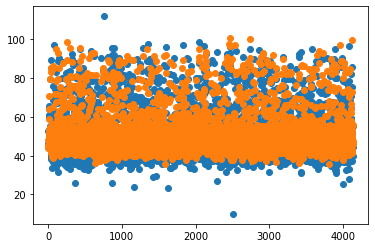

[46.2 46.1 52.8 48.4 53.4 65.7 59.7 50.3 46.9 46.7]
[[45.405865]
 [43.703583]
 [48.114815]
 [51.06482 ]
 [49.946022]
 [52.54754 ]
 [58.698135]
 [52.459347]
 [49.2043  ]
 [49.56124 ]]


In [17]:
plt.scatter(np.arange(0,len(y_test)), y_test)
plt.scatter(np.arange(0,len(y_test)), y_pred)
plt.show()

print(y_test[0:10])
print(y_pred[0:10])

In [18]:
df_test = pd.read_csv('test.csv', low_memory=False); df_test

X_kaggle = np.stack(df_test.protein_sequence.values,axis=0)
kaggle_embeddings = get_embeddings(X_kaggle)

Batch 0
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 10
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 20
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 30
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 40
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 50
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 60
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 70
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 80
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
(4, 1024)
Batch 90
(4, 1024)
(

76/76 [==============================] - 0s 1ms/step


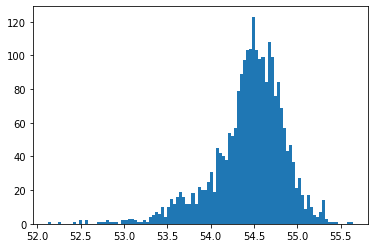

In [19]:
import matplotlib.pyplot as plt

predictions = m.predict(kaggle_embeddings)
pY = pd.DataFrame(predictions, index=range(31390,len(predictions)+31390), columns=['tm'])

plt.hist(pY.tm, bins=100)
plt.show()

In [20]:
ToCSV = lambda df_tmp, fname: df_tmp.round(2).to_csv(f'{fname}.csv', index_label='seq_id')
ToCSV(pY, '/content/gdrive/MyDrive/Kaggle/Novozymes_Submission')